# 25B · Watershed en píldoras (IDs por objeto)

Imports y rutas de imagen

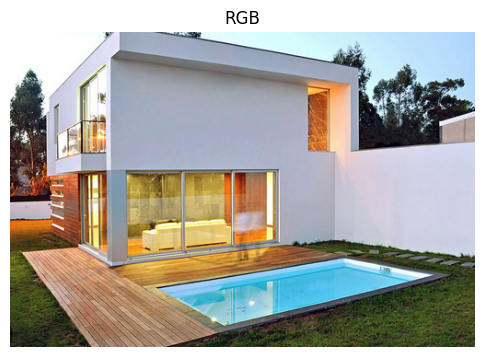

In [56]:
import cv2, numpy as np, matplotlib.pyplot as plt, pandas as pd

# Imagen
IMG_PATH = r"C:\Users\20808\Documents\Repositorios\Vision_en_Robotica\imagenes\casa.png"


bgr = cv2.imread(IMG_PATH, cv2.IMREAD_COLOR)
if bgr is None:
    raise FileNotFoundError(f"No se pudo cargar la imagen: {IMG_PATH}")
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,6))
plt.imshow(rgb); plt.title("RGB"); plt.axis("off"); plt.show()

Conversión a grises y análisis de brillo para decidir polaridad de umbral.

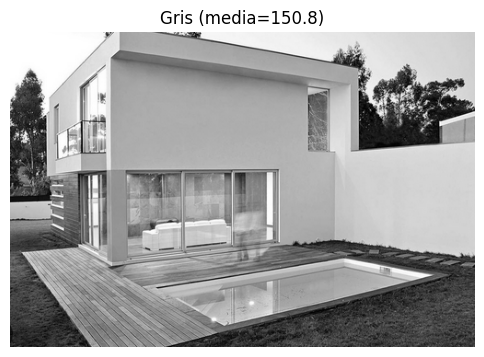

In [57]:
gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
mean_intensity = gray.mean()

plt.figure(figsize=(6,6))
plt.imshow(gray, cmap="gray"); plt.title(f"Gris (media={mean_intensity:.1f})"); plt.axis("off"); plt.show()

# Fondo blanco -> usar THRESH_BINARY_INV; fondo negro -> THRESH_BINARY
use_inverse = mean_intensity > 127
th_mode = cv2.THRESH_BINARY_INV if use_inverse else cv2.THRESH_BINARY

Suavizado gaussiano y umbralización (Otsu con polaridad seleccionada).

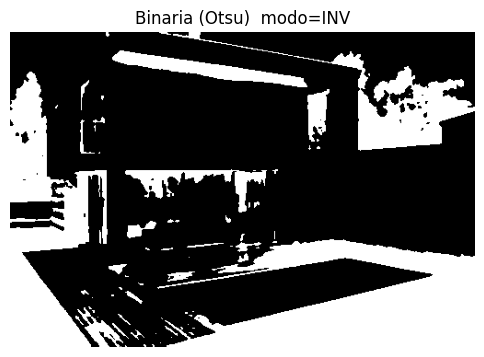

In [58]:
gray_blur = cv2.GaussianBlur(gray, (5,5), 0)
_, th = cv2.threshold(gray_blur, 0, 255, th_mode + cv2.THRESH_OTSU)

plt.figure(figsize=(6,6))
plt.imshow(th, cmap="gray")
plt.title(f"Binaria (Otsu)  modo={'INV' if use_inverse else 'BIN'}")
plt.axis("off"); plt.show()

Apertura morfológica y fondo seguro por dilatación.

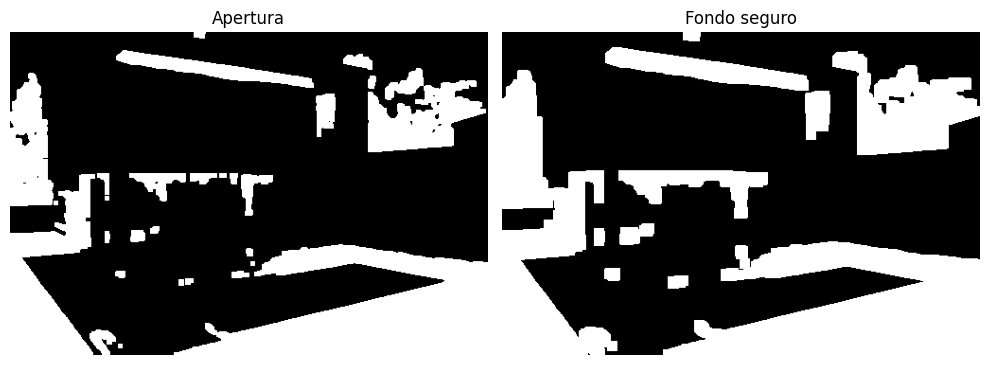

In [59]:
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel, iterations=2)
sure_bg = cv2.dilate(opening, kernel, iterations=3)

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1,2,1); ax1.imshow(opening, cmap="gray"); ax1.set_title("Apertura"); ax1.axis("off")
ax2 = fig.add_subplot(1,2,2); ax2.imshow(sure_bg, cmap="gray"); ax2.set_title("Fondo seguro"); ax2.axis("off")
plt.tight_layout(); plt.show()

Transformada de distancia y primer plano seguro (umbral relativo).

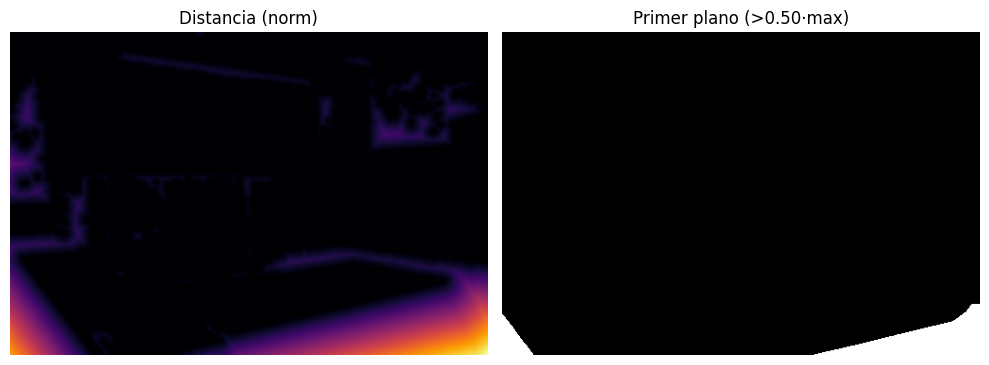

In [60]:
dist = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
# Ajustar el umbral relativo si los objetos se pegan (0.35–0.65 sugerido)
th_rel = 0.50
_, sure_fg = cv2.threshold(dist, th_rel*dist.max(), 255, 0)
sure_fg = sure_fg.astype(np.uint8)

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1,2,1); ax1.imshow(cv2.normalize(dist, None, 0, 1.0, cv2.NORM_MINMAX), cmap="inferno"); ax1.set_title("Distancia (norm)"); ax1.axis("off")
ax2 = fig.add_subplot(1,2,2); ax2.imshow(sure_fg, cmap="gray"); ax2.set_title(f"Primer plano (>{th_rel:.2f}·max)"); ax2.axis("off")
plt.tight_layout(); plt.show()

Región desconocida y marcadores por componentes conectadas.

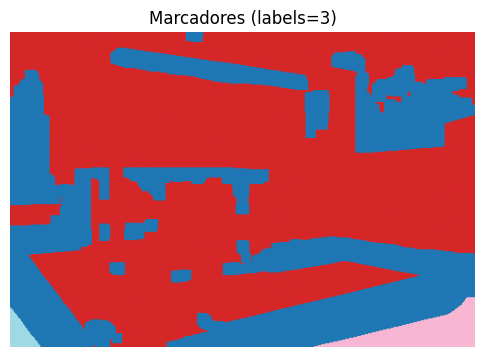

In [61]:
unknown = cv2.subtract(sure_bg, sure_fg)

num_labels, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown==255] = 0

plt.figure(figsize=(6,6))
plt.imshow(markers, cmap="tab20"); plt.title(f"Marcadores (labels={num_labels})"); plt.axis("off"); plt.show()

Aplicación de Watershed y extracción de bordes.

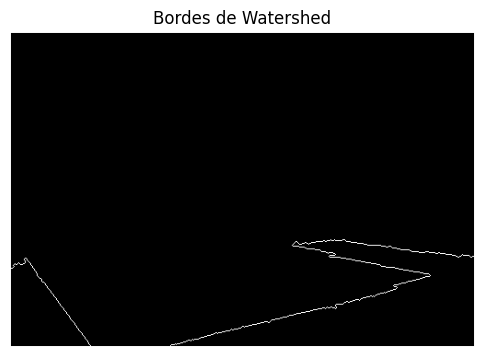

In [62]:
markers_ws = markers.copy()
markers_ws = cv2.watershed(bgr, markers_ws)

edges = (markers_ws == -1).astype(np.uint8) * 255

plt.figure(figsize=(6,6))
plt.imshow(edges, cmap="gray"); plt.title("Bordes de Watershed"); plt.axis("off"); plt.show()

Etiqueta única por objeto: mapa de colores, centroides y numeración.

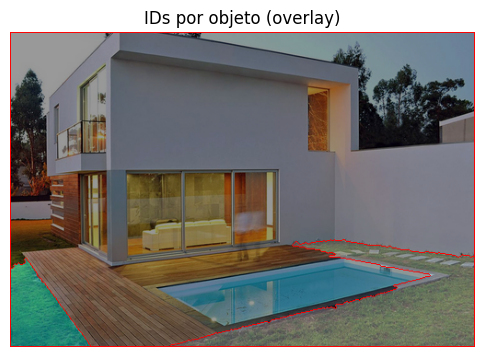

,ID,cx,cy,x0,y0,x1,y1
0,2,399.429304,299.123258,175,226,503,340
1,3,30.732927,305.190796,1,246,86,340


In [63]:
labels = markers_ws.copy()
labels[labels<=1] = 0  # 0=fondo/indeterminado; IDs reales >=2

# Paleta pseudo-aleatoria estable
ids = np.unique(labels)
ids = ids[ids>=2]
rng = np.random.default_rng(1234)
color_map = {i: rng.integers(0,256, size=3, dtype=np.uint8) for i in ids}

colored = np.zeros_like(bgr)
for i in ids:
    colored[labels==i] = color_map[i]

overlay = cv2.addWeighted(rgb, 0.6, cv2.cvtColor(colored, cv2.COLOR_BGR2RGB), 0.4, 0)
overlay[edges==255] = [255, 0, 0]

plt.figure(figsize=(6,6))
plt.imshow(overlay); plt.title("IDs por objeto (overlay)"); plt.axis("off"); plt.show()

# Cálculo de centroides y cajas
props = []
for i in ids:
    ys, xs = np.where(labels==i)
    if len(xs)==0: 
        continue
    cx, cy = xs.mean(), ys.mean()
    x0, y0, x1, y1 = xs.min(), ys.min(), xs.max(), ys.max()
    props.append((int(i), float(cx), float(cy), int(x0), int(y0), int(x1), int(y1)))

df = pd.DataFrame(props, columns=["ID","cx","cy","x0","y0","x1","y1"])
df.sort_values("ID", inplace=True)
df

Visualización de etiquetas con numeración en la imagen.

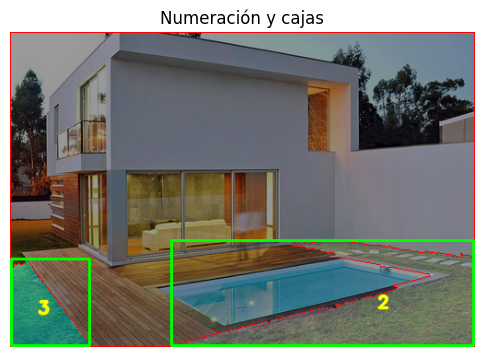

In [64]:
vis = overlay.copy()
for (i, cx, cy, x0, y0, x1, y1) in props:
    cv2.rectangle(vis, (x0,y0), (x1,y1), (0,255,0), 2)
    cv2.putText(vis, str(i), (int(cx), int(cy)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,0), 2, cv2.LINE_AA)

plt.figure(figsize=(6,6))
plt.imshow(vis); plt.title("Numeración y cajas"); plt.axis("off"); plt.show()